# Movie Ratings - Classification Model

In [1]:
# Import initial dependencies
import pandas as pd
import os
import nltk
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# Import movies dataframe
movies_df = pd.read_csv("https://data-bootcamp-ztc.s3.amazonaws.com/movies_complete_cleaned.csv")
movies_df.head(2)

,name,production,director,runtime,released,year,month,country_kaggle,country_omdb,star_kaggle,...,plot,awards,score_imdb,votes_imdb,score_metacritic,budget,genre_kaggle,gross,genres_omdb,rating
0,Doctor Strange,Marvel Studios,Scott Derrickson,115,2016-11-04,2016,11,USA,USA,Benedict Cumberbatch,...,"Marvel's ""Doctor Strange"" follows the story of...",Nominated for 1 Oscar. Another 19 wins & 67 no...,7.5,348307,72.0,165000000,Action,232641920,"Action, Adventure, Fantasy, Sci-Fi",PG-13
1,Sleight,Diablo Entertainment (II),J.D. Dillard,89,2017-04-28,2016,4,USA,USA,Jacob Latimore,...,A young street magician (Jacob Latimore) is le...,3 nominations.,5.9,4012,62.0,250000,Action,3986245,"Crime, Drama, Sci-Fi",R


In [3]:
movies_df["rating"].value_counts()

R        3261
PG-13    1903
PG        927
G         143
NC-17      22
Name: rating, dtype: int64

In [4]:
#drop NC-17 as there are very few instances
movies_df = movies_df[movies_df["rating"]  != "NC-17"]

In [5]:
# movies_df["genre_kaggle"].value_counts()

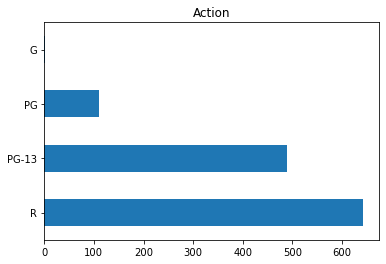

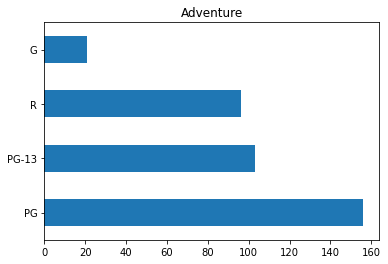

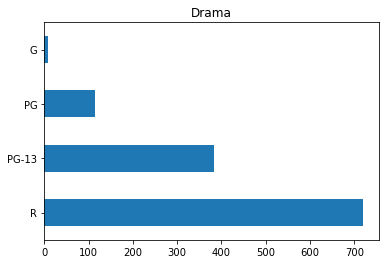

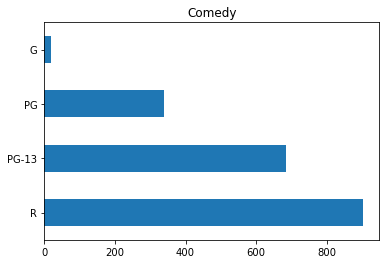

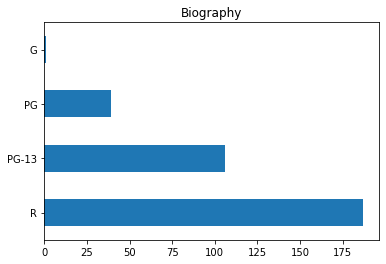

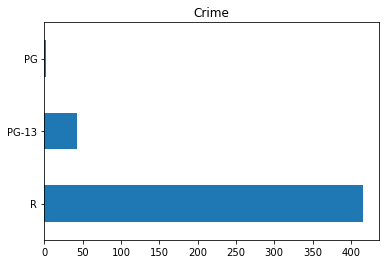

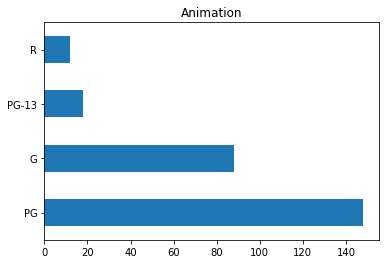

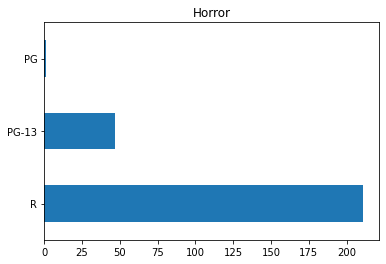

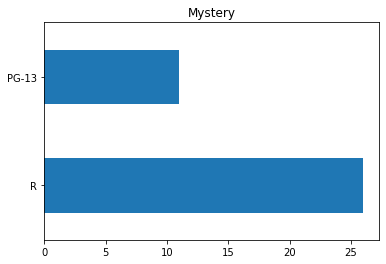

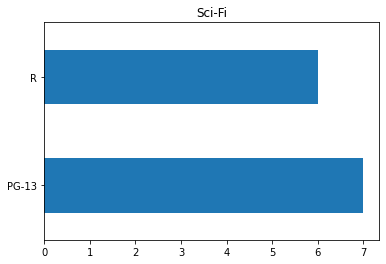

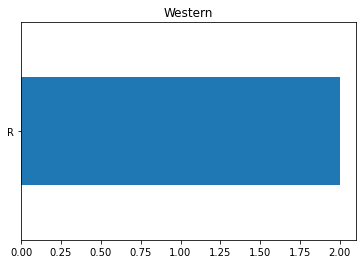

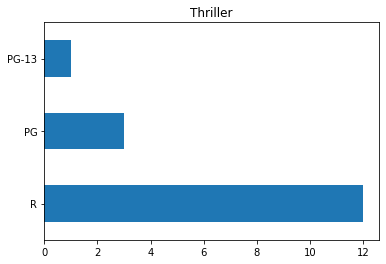

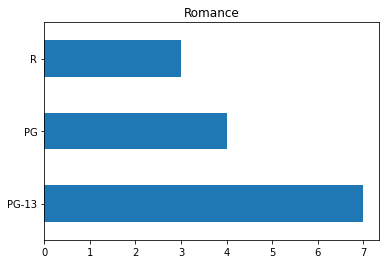

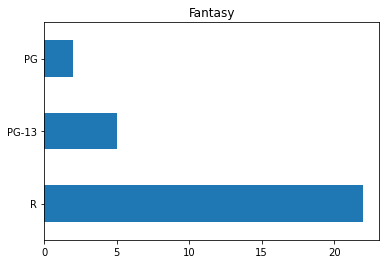

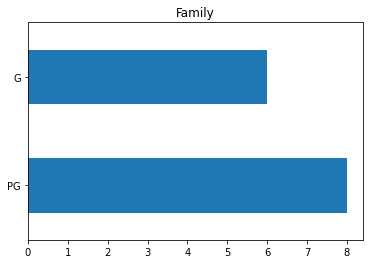

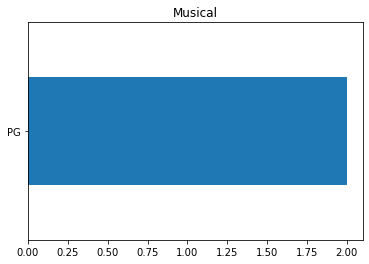

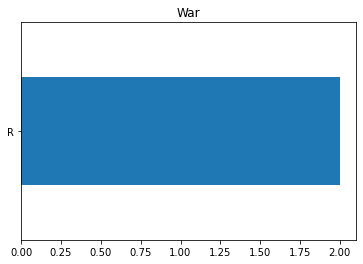

In [6]:
for genre in movies_df['genre_kaggle'].unique():
#     print(genre)
    df = movies_df[movies_df['genre_kaggle']==genre]  
#     print(len(df))
    plt.figure()
    plt.title(genre)
    df['rating'].value_counts().plot(kind='barh')

plt.show()

## Cleaning Data for Tokenization

In [7]:
# Extract plot data
df = movies_df[["name", "plot","rating"]]
df.set_index("name",inplace = True)
df.head()

,plot,rating
name,,
Doctor Strange,"Marvel's ""Doctor Strange"" follows the story of...",PG-13
Sleight,A young street magician (Jacob Latimore) is le...,R
Silence,The story of two Catholic missionaries (Andrew...,R
Manchester by the Sea,"Lee Chandler is a brooding, irritable loner wh...",R
Dirty Grandpa,"Jason Kelly, the grandson of Dick Kelly, loses...",R


In [8]:
df = df.dropna(axis='index', subset=['plot'])
df["plot_len"] = [len(x) for x in df["plot"]]

In [9]:
# Remove punctuation
import string


def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)


df["plot"] = [remove_punct(x) for x in df["plot"]]

In [10]:
# Remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))


def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)


df["plot"] = [remove_stopwords(x) for x in df["plot"]]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniellepintacasi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#adding plot length feature



In [12]:
df

,plot,rating,plot_len
name,,,
Doctor Strange,marvels doctor strange follows story talented ...,PG-13,464
Sleight,young street magician jacob latimore left care...,R,289
Silence,story two catholic missionaries andrew garfiel...,R,254
Manchester by the Sea,lee chandler brooding irritable loner works ha...,R,420
Dirty Grandpa,jason kelly grandson dick kelly loses grandmot...,R,344
...,...,...,...
Hoosiers,based true story smalltown indiana team made s...,PG,236
Off Beat,traumatised paramedic looks woman dreams,PG,56
Big Trouble in Little China,truck driver jack burton arrives chinatown san...,PG-13,805


### Encode Ratings Label

In [13]:
# Import label encoder 
from sklearn import preprocessing

# Set label encoder method to variable for use
label_encoder = preprocessing.LabelEncoder()

# Encode ratigs  
df["encoded_rating"] = label_encoder.fit_transform(df["rating"]) 
df.head()

,plot,rating,plot_len,encoded_rating
name,,,,
Doctor Strange,marvels doctor strange follows story talented ...,PG-13,464,2
Sleight,young street magician jacob latimore left care...,R,289,3
Silence,story two catholic missionaries andrew garfiel...,R,254,3
Manchester by the Sea,lee chandler brooding irritable loner works ha...,R,420,3
Dirty Grandpa,jason kelly grandson dick kelly loses grandmot...,R,344,3


In [14]:
print("check encoding:")
print("---------------------------------------------------------------------------")
print(df.rating.value_counts())
print("---------------------------------------------------------------------------")
print(df.encoded_rating.value_counts())

check encoding:
---------------------------------------------------------------------------
R        3071
PG-13    1813
PG        883
G         128
Name: rating, dtype: int64
---------------------------------------------------------------------------
3    3071
2    1813
1     883
0     128
Name: encoded_rating, dtype: int64


### Encoding Genre and converting it into a matrix

In [15]:
genres = pd.read_csv("https://data-bootcamp-ztc.s3.amazonaws.com/parsed_genres_table.csv")  # one hot encoding genres
genres.set_index("name", inplace = True)
genres = genres.drop(columns = ["genre_kaggle", "genres_omdb"])
genres.head(3)

,action,adventure,fantasy,sci-fi,crime,drama,history,comedy,biography,romance,...,family,sport,music,mystery,short,western,musical,documentary,film-noir,adult
name,,,,,,,,,,,,,,,,,,,,,
Doctor Strange,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sleight,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Silence,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
clean_df = pd.merge(df, genres, how = "inner", on = "name")
clean_df.head(2)
# import scipy
# from scipy.sparse import csr_matrix
# genres_mat = scipy.sparse.csr_matrix(genres.values)
# genres_mat

,plot,rating,plot_len,encoded_rating,action,adventure,fantasy,sci-fi,crime,drama,...,family,sport,music,mystery,short,western,musical,documentary,film-noir,adult
name,,,,,,,,,,,,,,,,,,,,,
Doctor Strange,marvels doctor strange follows story talented ...,PG-13,464,2,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Sleight,young street magician jacob latimore left care...,R,289,3,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# clean_df.isnull().sum()

## Split Data

In [18]:
from sklearn.model_selection import train_test_split
X = clean_df.drop(columns = ["rating","encoded_rating"])
y = clean_df["encoded_rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train

,plot,plot_len,action,adventure,fantasy,sci-fi,crime,drama,history,comedy,...,family,sport,music,mystery,short,western,musical,documentary,film-noir,adult
name,,,,,,,,,,,,,,,,,,,,,
Water for Elephants,parents death jacob jankowski left penniless h...,376,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
The Lizzie McGuire Movie,teen queen lizzie mcguire grows bit hits big s...,1077,0,1,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
Let's Go to Prison,john lyshitski young man prison often entire c...,1362,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10 Years,night high school reunion group friends realiz...,114,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Two Moon Junction,april graduated exclusive southern college she...,520,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jingle All the Way,meet howard langston salesman mattress company...,664,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
Immediate Family,linda michael married ten years desperately wa...,308,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Cookie,paroled labor racketeer dapper dino sought pol...,182,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Tokenization

In [19]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# hash plot
cv = HashingVectorizer().fit(X_train["plot"])
X_train_counts = cv.transform(X_train["plot"])
X_test_counts = cv.transform(X_test["plot"])

# pass the hashed vector through a tfidf transformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tfidf = tf_transformer.transform(X_train_counts)
X_test_tfidf = tf_transformer.transform(X_test_counts)

print("------------------------------")
print(f"Type: {type(X_train_tfidf)}")
print(f"Shape : {X_train_tfidf.shape}")
print("------------------------------")
print("See one vector to check: \n")
print(X_train_tfidf)

"""alternative vectorizor"""
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer().fit(X_train["plot"])


# X_train_tfidf = vectorizer.transform(X_train["plot"])
# X_test_tfidf = vectorizer.transform(X_test["plot"])


------------------------------
Type: <class 'scipy.sparse.csr.csr_matrix'>
Shape : (4420, 1048576)
------------------------------
See one vector to check: 

  (0, 1047404)	-0.14353251889794175
  (0, 1036687)	0.1853268562788059
  (0, 999705)	0.1321901687192151
  (0, 932074)	0.35522063727664094
  (0, 920155)	0.3860867878385826
  (0, 869863)	-0.1276618622332636
  (0, 779551)	0.23338747844118218
  (0, 767195)	-0.10868166438609576
  (0, 758978)	-0.12334168489559938
  (0, 728023)	-0.12100776620553749
  (0, 704780)	-0.1214172878082159
  (0, 704556)	-0.20880968024237387
  (0, 673732)	0.09871958752248178
  (0, 672777)	-0.08234067421860514
  (0, 672587)	-0.10999678777062567
  (0, 606279)	-0.10792246812382217
  (0, 555581)	0.12001050844975987
  (0, 530489)	-0.09379965797003842
  (0, 463730)	0.17598417568057634
  (0, 441259)	0.1251764610852203
  (0, 392855)	0.18766077496886774
  (0, 380136)	-0.11195350928895997
  (0, 379061)	0.20391924287975977
  (0, 367561)	0.11137973032088308
  (0, 343575)	-0.23

'alternative vectorizor'

In [20]:
# These features and y values are chosen to be scaled because the data is heavily skewed
from sklearn.preprocessing import MinMaxScaler

# Transform selected X ('runtime', 'votes_imdb', 'adjusted_budget')
X_scaler = MinMaxScaler().fit(X_train["plot_len"].values.reshape(-1,1))

X_train["plot_len"] = X_scaler.transform(X_train["plot_len"].values.reshape(-1,1))
X_test["plot_len"] = X_scaler.transform(X_test["plot_len"].values.reshape(-1,1))

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
#create matrix with other features data

import numpy as np
from scipy.sparse import csr_matrix

X_train_extra_features_mat = csr_matrix(X_train.drop(columns=["plot"])) #run these lines to include plot len
X_test_extra_features_mat = csr_matrix(X_test.drop(columns=["plot"])) #run these lines to include plot len
# X_train_extra_features_mat = csr_matrix(X_train.drop(columns=["plot", "plot_len"]))
# X_test_extra_features_mat = csr_matrix(X_test.drop(columns=["plot", "plot_len"]))
X_train_extra_features_mat.todense()

matrix([[0.11924822, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.34640311, 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.43875567, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.05638367, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.06740117, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.20187946, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [22]:
#combine both matices 
from scipy.sparse import hstack

X_train_full = hstack([X_train_tfidf, X_train_extra_features_mat])
X_test_full = hstack([X_test_tfidf, X_test_extra_features_mat])

print(X_train_full.shape)
print(X_test_full.shape)

(4420, 1048601)
(1474, 1048601)


### Train and Fit Model

In [23]:
from sklearn.svm import LinearSVC 

model = LinearSVC(class_weight='balanced',
                        verbose=2, random_state=42,
                        max_iter=100000)
model.fit(X_train_full, y_train)

[LibLinear]

LinearSVC(class_weight='balanced', max_iter=100000, random_state=42, verbose=2)

In [24]:
# Calculate classification report
from sklearn.metrics import classification_report

predictions = model.predict(X_test_full)
target_names = ["G", "PG", "PG-13", "R"]
print(classification_report(y_test, predictions,
                            target_names=target_names))

              precision    recall  f1-score   support

           G       0.60      0.18      0.28        33
          PG       0.69      0.53      0.60       219
       PG-13       0.49      0.48      0.48       444
           R       0.70      0.78      0.74       778

    accuracy                           0.64      1474
   macro avg       0.62      0.49      0.53      1474
weighted avg       0.63      0.64      0.63      1474



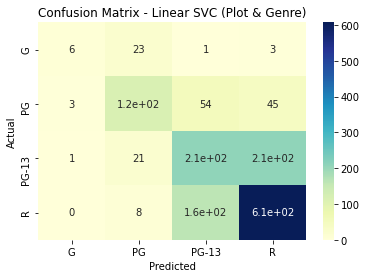

In [25]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm, index=['G', 'PG', 'PG-13', 'R'], columns=['G', 'PG', 'PG-13', 'R'])

heatmap = sn.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title("Confusion Matrix - Linear SVC (Plot & Genre)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig('../../image_highlights/rating_svc/final_model_confusion_matrix_linear_svc_with_genre.png')
plt.show()

In [26]:
# """
# With genres with balancing
# """
#join ifidf vector and genre data


# Support vector machine linear classifier
# from sklearn.svm import SVC 
# model = SVC(kernel='linear',  class_weight='balanced')
# model.fit(X_train_full, y_train)

# # Calculate classification report
# from sklearn.metrics import classification_report
# target_names = ["G", "PG", "PG-13", "R"]
# predictions = model.predict(X_test_full)
# print(classification_report(y_test, predictions,
#                             target_names=target_names))

In [27]:
# """
# without genre with balancing
# """

# target_names = ["G", "PG", "PG-13", "R"]

# # Support vector machine linear classifier
# from sklearn.svm import SVC 
# model = SVC(kernel='linear',  class_weight='balanced')
# model.fit(X_train_tfidf, y_train)

# # Calculate classification report
# from sklearn.metrics import classification_report
# predictions = model.predict(X_test_tfidf)
# print(classification_report(y_test, predictions,
#                             target_names=target_names))

In [28]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report

# target_names = ["G", "PG", "PG-13", "R"]


# # Set the parameters by cross-validation
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000] },
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# scores = ['precision', 'recall']

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(
#         SVC(class_weight = "balanced"), tuned_parameters, scoring='%s_macro' % score
#     )
#     clf.fit(X_train_full, y_train)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test_full)
#     print(classification_report(y_true, y_pred))
#     print()

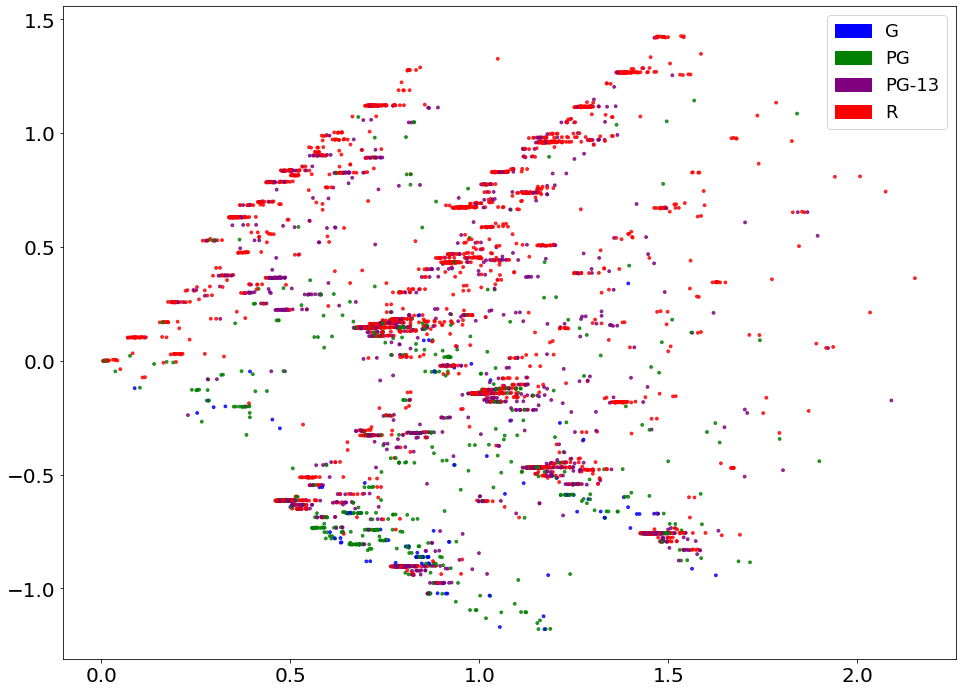

In [36]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt

import matplotlib 
import matplotlib.patches as mpatches


# X_full = hstack([X_train_tfidf,genres_mat])
# X_tfidf = hstack([train_tfidf])
# y = ratings["encoded_rating"]
test_labels = ["G", "PG", "PG-13", "R"]

def plot_LSA(test_data, test_labels, plot=True):
    """
    This function first uses SK-Learn's truncated SVD (LSA) class to 
    transform the high dimensionality (number of columns) of the BoW 
    embedding down to 2 dimensions. Then the two dimensions are used
    to plot each song, colored by the song writer (class).
    
    Inputs:
        test_data (pd.DataFrame): BoW embeddings.
        test_labels (pd.Series): In this case the songwriter of each
        Beatles' song.
        plot (boolean): Whether or not to plot. Defaults to True.
    
    Outputs:
        None.
    """
    
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['blue','green','purple', 'red']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        blue_patch = mpatches.Patch(color='blue', label='G')
        green_patch = mpatches.Patch(color='green', label='PG')
        purple_patch = mpatches.Patch(color='purple', label='PG-13')
        orange_patch = mpatches.Patch(color='red', label='R')
        plt.legend(handles=[blue_patch, green_patch, purple_patch, orange_patch], prop={'size': 18})
#         plt.xlabel('Principal Component One')
#         plt.ylabel('Principal Component Two')
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20

plt.figure(1, figsize=(16, 12))
# plt.subplot(3, 1, 1)
# plot_LSA(X_train_tfidf, y_train)
# plt.subplot(3, 1, 2)
# plot_LSA(X_train_extra_features_mat, y_train)
# plt.subplot(3, 1, 3)
plt.subplot()
plot_LSA(X_train_full, y_train)


## Export 

In [30]:
import joblib



filename = os.path.join(
    "..", "..", "saved_models", "ratings_SVM_classifier.sav"
)
joblib.dump(model, filename)

filename = os.path.join(
    "..", "..", "flask_app", "ratings_SVM_classifier.sav"
)
joblib.dump(model, filename)

['../../flask_app/ratings_SVM_classifier.sav']

In [31]:
X_train_full.shape

(4420, 1048601)